In [1]:
'''
3D VoxNet
这个模型本来是针对大规模点云体素化的，但目前我们的数据规模反倒很小，于是我没有照搬原模型中点云体素化的方法，而只使用了它的网络结构。
网络结构：与3D CNN相比，最前端多了一层更大、更稀疏的3D卷积，此外完全相同。
'''

'\n3D VoxNet\n这个模型本来是针对大规模点云体素化的，但目前我们的数据规模反倒很小，于是我没有照搬原模型中点云体素化的方法，而只使用了它的网络结构。\n网络结构：与3D CNN相比，最前端多了一层更大、更稀疏的3D卷积，此外完全相同。\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import trimesh

In [3]:
# 加载和归一化模型
def load_mesh(file_path):
    mesh = trimesh.load(file_path)
    # 如果加载的是Scene对象，转换为Trimesh对象
    if isinstance(mesh, trimesh.Scene):
        mesh = mesh.dump(concatenate=True)
    return mesh

def normalize_mesh(mesh):
    # 将网格中心平移到原点
    mesh.apply_translation(-mesh.centroid)
    # 计算缩放比例
    scale_factor = 1.0 / max(mesh.extents)
    # 缩放网格
    mesh.apply_scale(scale_factor)
    return mesh

def mesh_to_voxel(mesh, voxel_size=32):
    # 将网格体素化
    voxelized_mesh = mesh.voxelized(pitch=1.0 / voxel_size)
    # 确保体素矩阵的形状为 (voxel_size, voxel_size, voxel_size)
    voxel_matrix = voxelized_mesh.matrix
    padded_matrix = np.zeros((voxel_size, voxel_size, voxel_size), dtype=voxel_matrix.dtype)
    shape = np.minimum(voxel_matrix.shape, (voxel_size, voxel_size, voxel_size))
    padded_matrix[:shape[0], :shape[1], :shape[2]] = voxel_matrix[:shape[0], :shape[1], :shape[2]]
    return padded_matrix

# 读取评分
def read_scores(score_file_path):
    indices = []
    scores = []
    with open(score_file_path, 'r') as f:
        for line in f:
            index, score = line.strip().split()
            indices.append(int(index))
            scores.append(int(score)-1)  # 离散化，-1，取值区间[0,4]
    return indices, scores  

# 定义数据集
class TeethDataset(Dataset):
    def __init__(self, score_file_path, voxel_size=32):
        self.indices, self.scores = read_scores(score_file_path)
        self.voxel_size = voxel_size

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        index = self.indices[idx]
        score = self.scores[idx]
        mesh_path = f'{index}.obj'
        mesh = normalize_mesh(load_mesh(mesh_path))
        voxel_data = mesh_to_voxel(mesh, self.voxel_size)
        return torch.tensor(voxel_data[np.newaxis, :], dtype=torch.float32), torch.tensor(score, dtype=torch.long)  # 确保 score 是 long 类型

# 创建数据集
score_file_path = 'grades.txt'
dataset = TeethDataset(score_file_path, voxel_size=32)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 

In [4]:
# 定义模型
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=2)  # VoxNet的第一层卷积
        self.conv2 = nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1)  # VoxNet的第二层卷积
        self.conv3 = nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1)  # VoxNet的第三层卷积
        self.fc1 = nn.Linear(32 * 4 * 4 * 4, 128)  # 体素尺寸为32*32*32，经过两次pooling变为4*4*4
        self.fc2 = nn.Linear(128, 5)  # 输出5个类别
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# 创建模型
model = VoxNet()
criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 学习率和优化器

# 训练模型
num_epochs = 30
all_targets = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # 记录targets、predictions用于模型评估
        all_targets.extend(targets.numpy())
        all_predictions.extend(outputs.detach().numpy())
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# 改成 numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)


# 模型评估
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(dataloader)}")

Epoch 1/30, Loss: 1.5356894135475159
Epoch 2/30, Loss: 1.5170964990791522
Epoch 3/30, Loss: 1.4850560960016752
Epoch 4/30, Loss: 1.497130064587844
Epoch 5/30, Loss: 1.473606194320478
Epoch 6/30, Loss: 1.474371574426952
Epoch 7/30, Loss: 1.4708464929932041
Epoch 8/30, Loss: 1.4917878853647333
Epoch 9/30, Loss: 1.45686632081082
Epoch 10/30, Loss: 1.4397206369199251
Epoch 11/30, Loss: 1.367177455048812
Epoch 12/30, Loss: 1.3505641049460362
Epoch 13/30, Loss: 1.3417065849429683
Epoch 14/30, Loss: 1.2046034696855044
Epoch 15/30, Loss: 1.0181002216903787
Epoch 16/30, Loss: 0.9044896775954648
Epoch 17/30, Loss: 0.7866157952107882
Epoch 18/30, Loss: 0.6653235460582533
Epoch 19/30, Loss: 0.5264877022096985
Epoch 20/30, Loss: 0.3314352768816446
Epoch 21/30, Loss: 0.31464370379322454
Epoch 22/30, Loss: 0.2347121707310802
Epoch 23/30, Loss: 0.26970855720145137
Epoch 24/30, Loss: 0.13880008417426756
Epoch 25/30, Loss: 0.0689468092505673
Epoch 26/30, Loss: 0.04352894735424534
Epoch 27/30, Loss: 0.04

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

     class 0       0.89      0.40      0.55       270
     class 1       0.76      0.53      0.62       810
     class 2       0.53      0.67      0.59      1470
     class 3       0.59      0.71      0.64      1410
     class 4       0.86      0.42      0.57       540

    accuracy                           0.61      4500
   macro avg       0.73      0.55      0.60      4500
weighted avg       0.65      0.61      0.61      4500



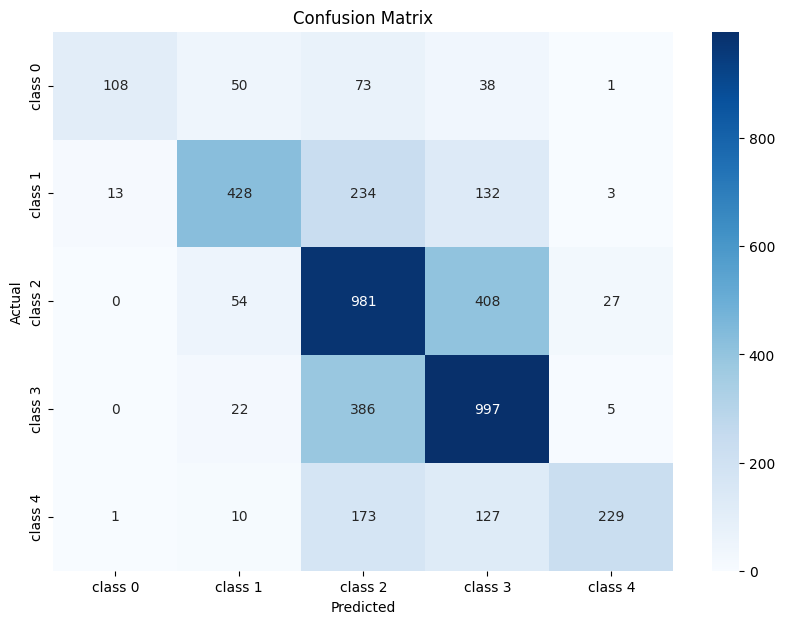

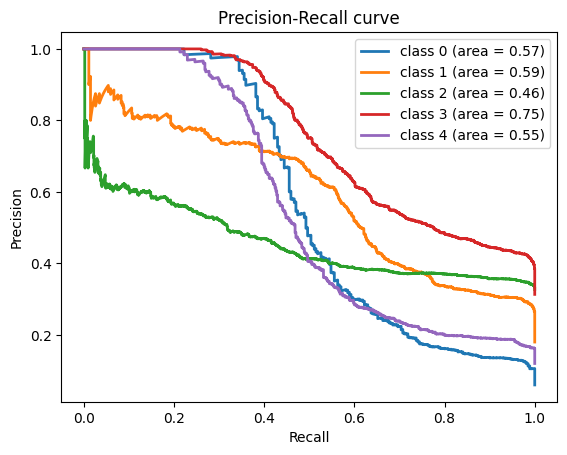

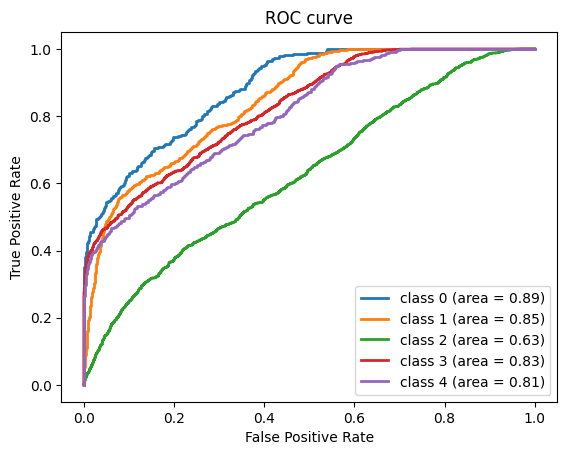

In [7]:
# 计算分类报告
report = classification_report(all_targets, all_predictions.argmax(axis=1), target_names=[f'class {i}' for i in range(5)])
print(report)

# 计算混淆矩阵
conf_matrix = confusion_matrix(all_targets, all_predictions.argmax(axis=1))

# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'class {i}' for i in range(5)], yticklabels=[f'class {i}' for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制 Precision-Recall 曲线和 ROC 曲线
precision = {}
recall = {}
pr_auc = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(all_targets == i, all_predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    fpr[i], tpr[i], _ = roc_curve(all_targets == i, all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 Precision-Recall 曲线
plt.figure()
for i in range(5):
    plt.plot(recall[i], precision[i], lw=2, label=f'class {i} (area = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

# 绘制 ROC 曲线
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'class {i} (area = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [8]:
# 对150个预备体进行评分
model.eval()
scores = []
with torch.no_grad():
    for i in range(len(dataset)):
        inputs, _ = dataset[i]  # 忽略目标评分，只取输入数据
        inputs = inputs.unsqueeze(0)  # 添加批次维度
        output = model(inputs)
        predicted_class = torch.argmax(output, dim=1).item() + 1
        scores.append(predicted_class)

# 输出150个预备体的评分
_, Real_Scores = read_scores(score_file_path)
Err_total = 0
for i, score in enumerate(scores):
    Err_total += abs(score-Real_Scores[i]-1)
    print(f'Tooth {i+1}: Score = {score}', f'Err = {score-Real_Scores[i]-1}' )

Tooth 1: Score = 4 Err = 0
Tooth 2: Score = 4 Err = 0
Tooth 3: Score = 3 Err = 0
Tooth 4: Score = 4 Err = 0
Tooth 5: Score = 4 Err = 0
Tooth 6: Score = 3 Err = 0
Tooth 7: Score = 4 Err = 0
Tooth 8: Score = 4 Err = 0
Tooth 9: Score = 4 Err = 0
Tooth 10: Score = 4 Err = 0
Tooth 11: Score = 1 Err = 0
Tooth 12: Score = 3 Err = 0
Tooth 13: Score = 3 Err = 0
Tooth 14: Score = 3 Err = 0
Tooth 15: Score = 3 Err = 0
Tooth 16: Score = 1 Err = 0
Tooth 17: Score = 3 Err = 0
Tooth 18: Score = 4 Err = 0
Tooth 19: Score = 3 Err = 0
Tooth 20: Score = 3 Err = 0
Tooth 21: Score = 4 Err = 0
Tooth 22: Score = 3 Err = 0
Tooth 23: Score = 4 Err = 0
Tooth 24: Score = 4 Err = 0
Tooth 25: Score = 5 Err = 0
Tooth 26: Score = 3 Err = 0
Tooth 27: Score = 4 Err = 0
Tooth 28: Score = 3 Err = 0
Tooth 29: Score = 3 Err = 0
Tooth 30: Score = 5 Err = 0
Tooth 31: Score = 3 Err = 0
Tooth 32: Score = 3 Err = 0
Tooth 33: Score = 4 Err = 0
Tooth 34: Score = 4 Err = 0
Tooth 35: Score = 3 Err = 0
Tooth 36: Score = 5 Err = 0
T